# 어뷰징 이란?
#### 게임에서 허용하지 않는 방법이나 시스템의 허점을 고의적으로 악용해서 부당한 이득을 취한 사람을 뜻하는 말이다.   
#### 즉 골드 파밍 어뷰징이란 시스템을 고의적으로 악용하여 골드의 이익을 취한 사람이다.

# 목표
#### 1. 사용자의 편의를 위해 고의적인 골드 파밍을 하는 유저를 선별하고, 클린 유저 -> 어뷰징 유저 예측 오류를 최소화하는 모델을 구축하여 보자

#### 참고 : https://zdnet.co.kr/view/?no=20160428151140 (2016년 넥슨 기계학습을 통한 어뷰징 검출 관련 기사)


## Library Import

In [1147]:
import pandas as pd
import numpy as np
import sklearn
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import os 
import re
import matplotlib.pyplot as plt

In [1148]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('Lightgbm : %s'%(lgbm.__version__))

!python --version

Pandas : 1.1.3
Numpy : 1.19.2
Scikit-Learn : 0.23.2
Lightgbm : 3.0.0
Python 3.7.9


In [130]:
path = os.getcwd()
df_train = pd.read_csv(path+'/abusingDetectionTrainDataset.csv',encoding='euc-kr')
df_test_x  = pd.read_csv(path+'/abusingDetectionTestDataset.csv',encoding='euc-kr')

## 데이터 EDA
> ###### 1. 데이터의 사이즈 확인     
> ###### 2. Train/Test 데이터 확인   
> ###### 3. Missing value 확인   
> ###### 4. Target Variable의 분포 (데이터 불균형 확인)   
> ###### 5. Target별 분포 확인  
> ###### 6. 데이터의 특이한/주목해야할 부분   



### 1. 데이터 사이즈 확인

In [131]:
print('Data size------------------------')
print('Train_Set shape: ',df_train.shape)
print('Test_Set shape: ',df_test_x.shape)

Data size------------------------
Train_Set shape:  (104399, 44)
Test_Set shape:  (44736, 43)


### 2. Train/Test 데이터 확인 ★	★	★	
#### 캐릭터가 시간대별로 성장하는? 연속적인 10개의 동일한 newID별로 데이터가 구성되어 있는것을 볼 수 있다. (하지만 도중에 다른 캐릭터로 변경하는 경우도 있음)
#### 이를 통해 학습 방법을 3가지로 나누어 생각해 볼 수 있다.

> 1. *동일한 newID를 가지는 연속적인 10개의 데이터를 묶어서 3차원으로 학습한뒤 예측하는 방법 (※ 데이터 부족 주의)* 
> 2. *동일한 newID를 가지는 연속적인 10개의 데이터를 pivot화 하여 한행으로 만들어서 예측하는 방법 (※ 데이터 부족 주의)*   
> 3. *일반적인 2차원 데이터로 학습한뒤 동일한 newID의 예측값중 1(제재)의 갯수로 어뷰징 예측하는 방법*   


#### ※ 2차원 데이터 학습시에 동일한 newID가 train과 valid set으로 분리되면서, 학습시에  newID가 예측값에 영향을 미칠수 있을것으로 예상. 　　　　　　　　　　　　　　　때문에 동일 newID를 분리 시키지 않거나 학습시 newID변수 제거후 학습 필요

In [5]:
def line_clear():
    print('====================================================')
print('newID별로 연속되는 10개의 데이터가 존재하는것을 볼 수 있다.')
line_clear()
df_train[df_train['newID']==1733]

newID별로 연속되는 10개의 데이터가 존재하는것을 볼 수 있다.


,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,...,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,tradeSessionAmountE,blocked
12346,1733,21,13,2017-6-17 0:47:1.566018,0,0,0,0,0,0,...,0,0,0,2,864,0,765,0,0,0
12347,1733,29,27,2017-6-17 1:17:2.78056,0,0,0,0,0,0,...,0,3,0,0,2456,0,1801,0,0,0
12348,1733,30,38,2017-6-17 1:47:2.406681,0,0,0,0,0,0,...,0,4,0,1,1266,0,1686,0,0,0
12349,1733,30,49,2017-6-17 2:17:10.116908,0,0,0,0,0,0,...,0,7,2,1,367,0,3120,0,0,0
12350,1733,30,55,2017-6-17 2:47:14.366697,0,0,0,0,0,0,...,0,7,0,0,369,0,3641,0,0,0
12351,1733,30,59,2017-6-17 3:17:14.853496,0,0,0,0,0,0,...,0,7,0,0,392,0,3630,0,0,0
12352,1733,31,60,2017-6-17 3:47:17.916794,0,0,0,0,0,0,...,0,0,0,1,164,0,573,0,0,0
12353,1733,31,62,2017-6-17 4:17:48.257823,0,0,0,0,0,0,...,0,0,0,0,468,0,630,0,0,0
12354,1733,31,65,2017-6-17 4:47:52.581024,0,0,0,0,0,0,...,0,0,0,0,560,0,697,0,0,0
12355,1733,31,70,2017-6-17 5:17:54.539055,0,0,0,0,0,0,...,0,1,0,0,804,0,1031,0,0,0


모든 데이터가 10개의 연속하는 데이터를 가지는것은 아니다.
2047     10
13011    10
7062     10
13203    10
11152    10
         ..
5866      9
12544     9
12962     9
42        6
14229     6
Name: newID, Length: 10441, dtype: int64
10203    10
11023    10
2795     10
8942     10
778      10
         ..
14834    10
5032      8
1463      6
1239      6
7072      6
Name: newID, Length: 4475, dtype: int64


연속되는 10개의 데이터가 없는 newID들


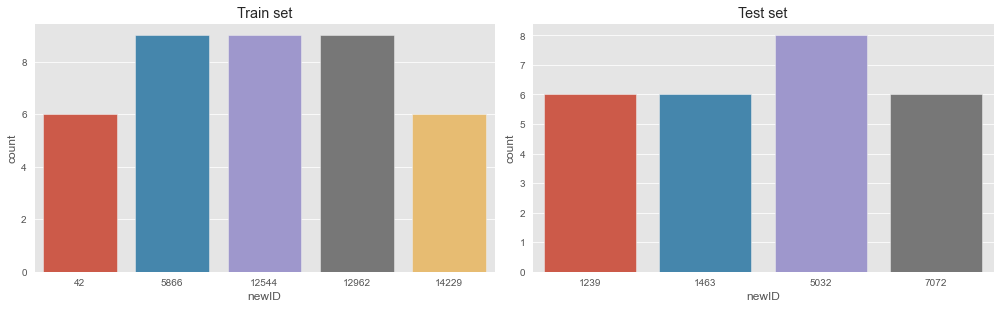

In [183]:

print('모든 데이터가 10개의 연속하는 데이터를 가지는것은 아니다.')
line_clear()
print(df_train['newID'].value_counts())
line_clear()
print(df_test_x['newID'].value_counts())

count_newID = df_train['newID'].value_counts().reset_index()
del_count_10_train = count_newID[count_newID['newID']!=10]
del_count_10_train

count_newID_test = df_test_x['newID'].value_counts().reset_index()
del_count_10_test = count_newID_test[count_newID_test['newID']!=10]
del_count_10_test


print('\n\n연속되는 10개의 데이터가 없는 newID들')
line_clear()
tmp = pd.DataFrame()
for i in del_count_10_train['index']: tmp=pd.concat([tmp,df_train[df_train['newID']==i]])
plt.style.use('ggplot')
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
sns.countplot(x='newID',data = tmp)
plt.title("Train set")


tmp = pd.DataFrame()
for i in del_count_10_test['index']: tmp=pd.concat([tmp,df_test_x[df_test_x['newID']==i]])
plt.subplot(2,2,2)
sns.countplot(x='newID',data = tmp)
plt.title("Test set")
plt.tight_layout()

plt.show()


### 3. Missing value 확인

In [9]:
print('Train data missing value 없음 ')
line_clear()
print(df_train.isnull().sum())

Train data missing value 없음 
newID                        0
char_jobcode                 0
char_level                   0
logging_timestamp            0
charStatA                    0
charStatB                    0
charStatC                    0
charStatD                    0
charStatE                    0
charStatF                    0
charStatG                    0
socialAmountA                0
socialBooleanA               0
socialBooleanB               0
socialSessionAmountA         0
activityCumulativeAmountA    0
accountMetaAmountA           0
charSessionAmountA           0
charSessionAmountB           0
charMoveSessionAmountA       0
charSessionAmountC           0
socialSessionAmountB         0
actionSessionAmountA         0
charSessionAmountD           0
activityCumulativeAmountB    0
actionSessionAmountB         0
actionSessionAmountC         0
actionSessionAmountD         0
actionSessionAmountE         0
tradeSessionAmountA          0
tradeSessionAmountB          0
tradeSessi

In [10]:
print('Test data missing value 없음')
line_clear()
print(df_test_x.isnull().sum())

Test data missing value 없음
newID                        0
char_jobcode                 0
char_level                   0
logging_timestamp            0
charStatA                    0
charStatB                    0
charStatC                    0
charStatD                    0
charStatE                    0
charStatF                    0
charStatG                    0
socialAmountA                0
socialBooleanA               0
socialBooleanB               0
socialSessionAmountA         0
activityCumulativeAmountA    0
accountMetaAmountA           0
charSessionAmountA           0
charSessionAmountB           0
charMoveSessionAmountA       0
charSessionAmountC           0
socialSessionAmountB         0
actionSessionAmountA         0
charSessionAmountD           0
activityCumulativeAmountB    0
actionSessionAmountB         0
actionSessionAmountC         0
actionSessionAmountD         0
actionSessionAmountE         0
tradeSessionAmountA          0
tradeSessionAmountB          0
tradeSession

### 4. Target Variable의 분포 (데이터 불균형 확인)
#### Under sampling 또는 다른 방안을 고려해볼 필요가 있음.

label 1 : 제재
label 0 : 비 제재
1    62460
0    41939
Name: blocked, dtype: int64


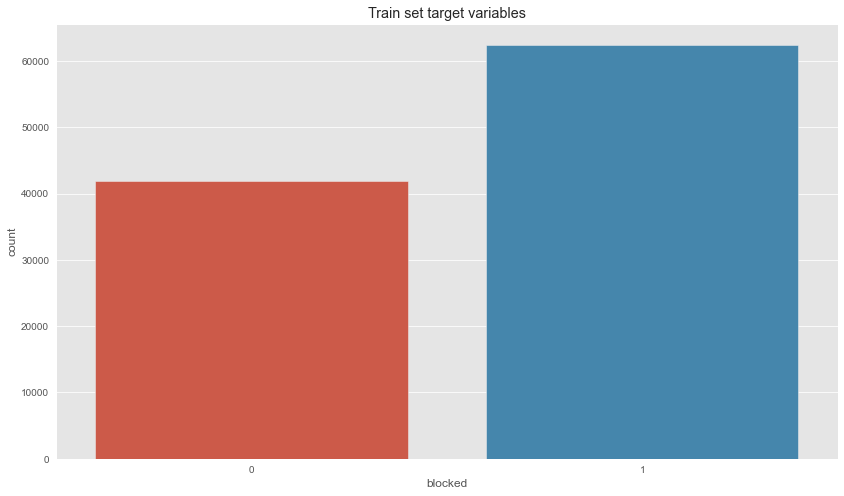

In [165]:
print('label 1 : 제재')
print('label 0 : 비 제재')
line_clear()
print(df_train['blocked'].value_counts())
line_clear()
plt.figure(figsize=(14, 8))
sns.countplot(x='blocked',data = df_train)
plt.title("Train set target variables")
plt.show()


### 5. Target별 분포 확인  
#### 요일별 분포를 위해 logging_TimeStamp 분리 및 요일 데이터로 변환 후 시각화

 0 : 월, 1 : 화, 2 : 수 ... 6 : 일


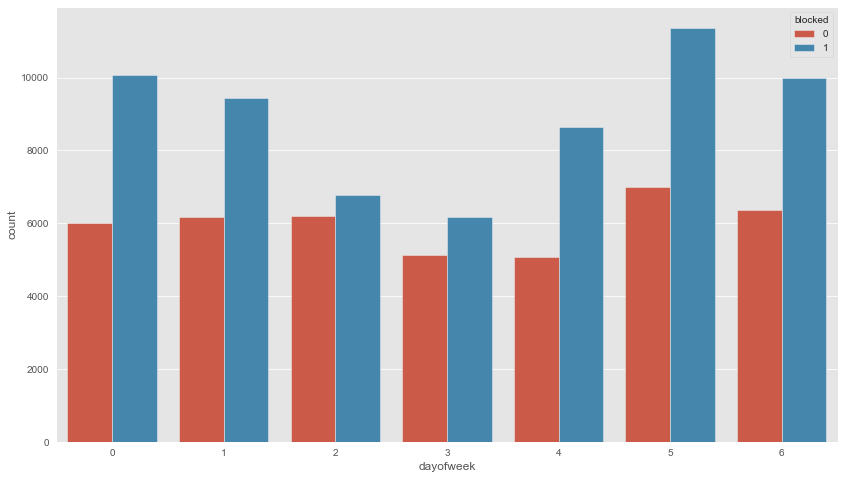

In [1079]:
def grap_day(data):
    data = data.split(' ')[0]
    return data

def grap_time(data):
    data = data.split(' ')[1]
    return data

df_train['day'] = df_train['logging_timestamp'].apply(grap_day)
df_train['time'] = df_train['logging_timestamp'].apply(grap_time)


df_test_x['day'] = df_test_x['logging_timestamp'].apply(grap_day)
df_test_x['time'] = df_test_x['logging_timestamp'].apply(grap_time)

from datetime import date

def return_Day_of_week(x):
    year , mon , day = x.split('-')
    return date(int(year), int(mon), int(day)).weekday()
    
df_train['dayofweek'] = df_train['day'].apply(return_Day_of_week)
df_test_x['dayofweek'] = df_test_x['day'].apply(return_Day_of_week)


print(' 0 : 월, 1 : 화, 2 : 수 ... 6 : 일')
plt.figure(figsize=(14, 8))
sns.countplot(data=df_train, x='dayofweek',hue=df_train['blocked'])
plt.show()

#### 캐릭터 레벨별 Target 분포

<Figure size 2160x576 with 0 Axes>

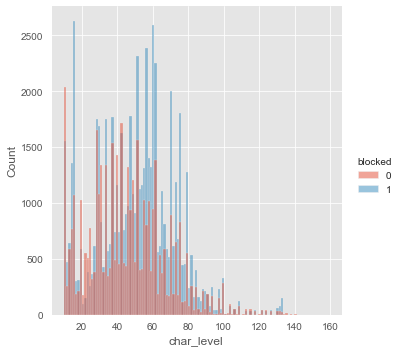

In [177]:
plt.figure(figsize=(30, 8))
sns.displot(data = df_train, x = 'char_level', hue = df_train['blocked'])
plt.show()

#### 액션의 수치별 Target분포

<Figure size 1440x864 with 0 Axes>

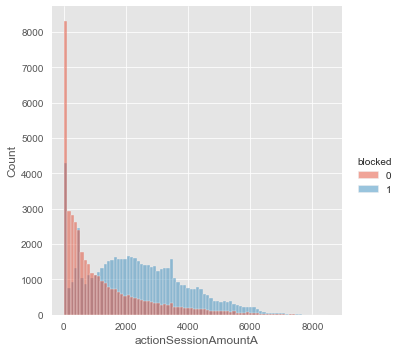

In [179]:
plt.figure(figsize = (20,12))
sns.displot(data = df_train, x = 'actionSessionAmountA', hue = df_train['blocked'])
plt.show()

### 6. 데이터의 특이한/주목해야할 부분
> 1. 유저가 파밍을 하지 않음에도 어뷰징 유저라고 판별난 사례들이 있음 (아래 코드 참조) -> 이상치로 판단하여 제거한뒤 학습을 진행 했지만 정확도가 내려가는것을 확인한 후 이상치라고 생각하지 않음
> 2. 제재 시점이 주어지지 않았기 때문에 제재 데이터 중에도 어뷰징을 사용하지 않은 시점이 섞여 있을수 있다는것을 생각하며 학습 진행
> 3. 어뷰징 유저 -> 클린 유저로 예측, 클린 유저 -> 어뷰징 유저를 예측하는 오류를 중요하게 생각하며 정확도 및 f1_score에 초점을 두며 진행

In [206]:
tmp = df_train[['newID','actionSessionAmountA','blocked']].groupby(['newID']).mean().reset_index()
tmp = tmp[tmp['blocked']==1].sort_values('actionSessionAmountA')
print('어뷰징 유저의 액션의 양의 평균치 계산')
line_clear()
print(tmp[tmp['actionSessionAmountA']<10])
line_clear()
print('표와 같이 어뷰징 유저이지만 레벨업을 안하는, 즉 액션의 양이없어도 어뷰징인경우가 있다.')
df_train[df_train['newID']==8610][['newID','char_level','actionSessionAmountA','blocked']]




어뷰징 유저의 액션의 양의 평균치 계산
      newID  actionSessionAmountA  blocked
6012   8642                   0.0      1.0
2631   3791                   1.3      1.0
5992   8610                   1.4      1.0
7413  10669                   1.5      1.0
7340  10561                   1.6      1.0
2333   3347                   1.6      1.0
4879   7008                   1.6      1.0
4090   5875                   1.7      1.0
3350   4792                   1.7      1.0
7081  10197                   1.7      1.0
7458  10730                   1.8      1.0
1469   2083                   1.8      1.0
7160  10310                   1.8      1.0
5440   7820                   1.9      1.0
2430   3505                   1.9      1.0
8654  12405                   1.9      1.0
8944  12797                   1.9      1.0
4695   6741                   1.9      1.0
3790   5446                   1.9      1.0
5719   8218                   2.0      1.0
8194  11760                   2.0      1.0
8648  12396                   2.

,newID,char_level,actionSessionAmountA,blocked
59915,8610,10,14,1
59916,8610,10,0,1
59917,8610,10,0,1
59918,8610,10,0,1
59919,8610,10,0,1
59920,8610,10,0,1
59921,8610,10,0,1
59922,8610,10,0,1
59923,8610,10,0,1
59924,8610,10,0,1


## 데이터 전처리
> ###### 1. 불필요 변수 제거
> ###### 2. 2가지 방법의 학습을 위한 데이터 셋 만들기 (2차원 데이터 , pivot화 데이터)
> ###### 　　2-1. Feature engineering
> ###### 　　2-2. 존재 하지 않는 값 처리 - 이전값 삽입 (pivot 데이터만 해당)


### 불필요 변수 제거
#### accountMetaAmountA , socialBooleanB, charSessionAmountB ,tradeSessionAmountC, tradeSessionAmountE 변수는 하나의 카테고리 값을 가지므로 제거한다

In [1082]:
print('제거 대상 변수 값 확인')
line_clear()
print(df_train['accountMetaAmountA'].value_counts())
line_clear()
print(df_train['socialBooleanB'].value_counts())
line_clear()
print(df_train['charSessionAmountB'].value_counts())
line_clear()
print(df_train['tradeSessionAmountC'].value_counts())
line_clear()
print(df_train['tradeSessionAmountE'].value_counts())
line_clear()

print('모두 하나의 값을 가지므로 변수에서 제거한다. timpstamp는 분리했기 때문에 제거, 요일을 뽑았기 때문에 day 변수 또한 제거')

#원본 데이터 유지
engin_train = df_train.copy()
engin_test = df_test_x.copy()

def grab_time(x):
    return x.split(':')[0]
engin_train['time'] = df_train['time'].apply(grab_time)
engin_test['time'] = df_test_x['time'].apply(grab_time)


engin_train.drop(['day','logging_timestamp','accountMetaAmountA','socialBooleanB','charSessionAmountB','tradeSessionAmountC','tradeSessionAmountE'],axis=1,inplace=True)
engin_test.drop(['day','logging_timestamp','accountMetaAmountA','socialBooleanB','charSessionAmountB','tradeSessionAmountC','tradeSessionAmountE'],axis=1,inplace=True)

print('Train set Columns 제거후 구조:',engin_train.shape)
print('Test set Columns 제거후 구조:',engin_test.shape)
engin_train

제거 대상 변수 값 확인
0    104399
Name: accountMetaAmountA, dtype: int64
0    104399
Name: socialBooleanB, dtype: int64
0    104399
Name: charSessionAmountB, dtype: int64
0    104399
Name: tradeSessionAmountC, dtype: int64
0    104399
Name: tradeSessionAmountE, dtype: int64
모두 하나의 값을 가지므로 변수에서 제거한다. timpstamp는 분리했기 때문에 제거, 요일을 뽑았기 때문에 day 변수 또한 제거
Train set Columns 제거후 구조: (104399, 40)
Test set Columns 제거후 구조: (44736, 39)


,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,blocked,time,dayofweek
0,0,0,10,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,8,0
1,0,0,31,0,0,0,0,2,0,0,...,0,0,2,146,0,106,0,0,9,0
2,0,0,40,0,0,0,0,2,0,0,...,0,0,2,229,0,172,0,0,9,0
3,0,0,61,0,0,0,0,6,0,0,...,2,0,2,583,0,615,0,0,10,0
4,0,0,61,0,0,0,0,6,0,0,...,1,0,17,1,0,0,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,1,0,4563,0,4575,0,1,...,4,0,0,89,0,59,0,0,16,0
104395,14915,132,16,0,0,4563,0,4563,0,0,...,0,0,0,45,0,44,0,0,12,0
104396,14915,132,23,0,0,4563,0,4565,0,0,...,0,0,0,195,0,153,0,0,12,0
104397,14915,132,27,0,0,4563,0,4565,0,0,...,1,0,0,193,0,152,0,0,13,0


### 2차원 데이터 만들기
> 1. 추가 요소 - 각 유저의 1행, 2행 전의 acition 수치 및 차분 값 추가

In [1121]:
engin_train

,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,blocked,time,dayofweek
0,14229.0,59.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,21,1.0
1,14229.0,59.0,18.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,110.0,0.0,169.0,0.0,0.0,21,1.0
2,14229.0,59.0,22.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,70.0,0.0,80.0,0.0,0.0,22,1.0
3,14229.0,59.0,27.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,87.0,0.0,127.0,0.0,0.0,22,1.0
4,14229.0,60.0,31.0,0.0,0.0,100.0,0.0,6.0,0.0,0.0,...,1.0,0.0,0.0,111.0,0.0,109.0,1.0,0.0,7,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104405,14915.0,120.0,47.0,1.0,0.0,4563.0,0.0,4575.0,0.0,1.0,...,4.0,0.0,0.0,89.0,0.0,59.0,0.0,0.0,16,0.0
104406,14915.0,132.0,16.0,0.0,0.0,4563.0,0.0,4563.0,0.0,0.0,...,0.0,0.0,0.0,45.0,0.0,44.0,0.0,0.0,12,0.0
104407,14915.0,132.0,23.0,0.0,0.0,4563.0,0.0,4565.0,0.0,0.0,...,0.0,0.0,0.0,195.0,0.0,153.0,0.0,0.0,12,0.0
104408,14915.0,132.0,27.0,0.0,0.0,4563.0,0.0,4565.0,0.0,0.0,...,1.0,0.0,0.0,193.0,0.0,152.0,0.0,0.0,13,0.0


In [217]:
# newID 별로 1,2전행의 값을 넣어주는 과정
newID = set(engin_train['newID'])
tmp= dict()
for i in newID:
    tmp[str(i)] = engin_train[engin_train['newID']==i].reset_index(drop=True)
    tmp[str(i)]['actionSessionAmountA_1'] = tmp[str(i)]['actionSessionAmountA'].shift(1)
    tmp[str(i)]['actionSessionAmountB_1'] = tmp[str(i)]['actionSessionAmountB'].shift(1)
    tmp[str(i)]['actionSessionAmountL_1'] = tmp[str(i)]['actionSessionAmountL'].shift(1)
    tmp[str(i)]['actionSessionAmountN_1'] = tmp[str(i)]['actionSessionAmountN'].shift(1)
    tmp[str(i)]['char_level_1'] = tmp[str(i)]['char_level'].shift(1)
    tmp[str(i)]['char_jobcode_1'] = tmp[str(i)]['char_jobcode'].shift(1)
    
    tmp[str(i)]['actionSessionAmountA_2'] = tmp[str(i)]['actionSessionAmountA'].shift(2)
    tmp[str(i)]['actionSessionAmountB_2'] = tmp[str(i)]['actionSessionAmountB'].shift(2)
    tmp[str(i)]['actionSessionAmountL_2'] = tmp[str(i)]['actionSessionAmountL'].shift(2)
    tmp[str(i)]['actionSessionAmountN_2'] = tmp[str(i)]['actionSessionAmountN'].shift(2)
    tmp[str(i)]['char_level_2'] = tmp[str(i)]['char_level'].shift(2)
    tmp[str(i)]['char_jobcode_2'] = tmp[str(i)]['char_jobcode'].shift(2)

    


##### 첫번째 행의 경우 이전 값이 없으므로 0으로 대치 시켜준다

In [219]:
tmp['0'].fillna(0)

,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,actionSessionAmountL_1,actionSessionAmountN_1,char_level_1,char_jobcode_1,actionSessionAmountA_2,actionSessionAmountB_2,actionSessionAmountL_2,actionSessionAmountN_2,char_level_2,char_jobcode_2
0,0,0,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,31,0,0,0,0,2,0,0,...,2.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,40,0,0,0,0,2,0,0,...,146.0,106.0,31.0,0.0,44.0,7.0,2.0,0.0,10.0,0.0
3,0,0,61,0,0,0,0,6,0,0,...,229.0,172.0,40.0,0.0,510.0,57.0,146.0,106.0,31.0,0.0
4,0,0,61,0,0,0,0,6,0,0,...,583.0,615.0,61.0,0.0,469.0,140.0,229.0,172.0,40.0,0.0
5,0,0,70,0,0,0,0,6,0,0,...,1.0,0.0,61.0,0.0,1146.0,945.0,583.0,615.0,61.0,0.0
6,0,0,91,0,0,0,0,8,0,0,...,895.0,498.0,70.0,0.0,65.0,46.0,1.0,0.0,61.0,0.0
7,0,0,91,0,0,0,0,8,0,0,...,943.0,1040.0,91.0,0.0,849.0,662.0,895.0,498.0,70.0,0.0
8,0,0,91,0,0,0,0,12,0,0,...,0.0,0.0,91.0,0.0,1620.0,1427.0,943.0,1040.0,91.0,0.0
9,0,0,100,0,35,0,0,12,0,0,...,0.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,91.0,0.0


In [221]:

df_train_2d = pd.DataFrame()
# 분리시켰던 newID별 데이터를 한곳으로 합치는 과정
for i in newID:
    tmp[str(i)] = tmp[str(i)].fillna(0)
    df_train_2d = pd.concat([df_train_2d,tmp[str(i)]],axis=0)
df_train_2d

,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,actionSessionAmountL_1,actionSessionAmountN_1,char_level_1,char_jobcode_1,actionSessionAmountA_2,actionSessionAmountB_2,actionSessionAmountL_2,actionSessionAmountN_2,char_level_2,char_jobcode_2
0,0,0,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,31,0,0,0,0,2,0,0,...,2.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,40,0,0,0,0,2,0,0,...,146.0,106.0,31.0,0.0,44.0,7.0,2.0,0.0,10.0,0.0
3,0,0,61,0,0,0,0,6,0,0,...,229.0,172.0,40.0,0.0,510.0,57.0,146.0,106.0,31.0,0.0
4,0,0,61,0,0,0,0,6,0,0,...,583.0,615.0,61.0,0.0,469.0,140.0,229.0,172.0,40.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,14915,120,47,1,0,4563,0,4575,0,1,...,22.0,14.0,44.0,120.0,460.0,45.0,177.0,90.0,42.0,120.0
6,14915,132,16,0,0,4563,0,4563,0,0,...,89.0,59.0,47.0,120.0,558.0,140.0,22.0,14.0,44.0,120.0
7,14915,132,23,0,0,4563,0,4565,0,0,...,45.0,44.0,16.0,132.0,872.0,76.0,89.0,59.0,47.0,120.0
8,14915,132,27,0,0,4563,0,4565,0,0,...,195.0,153.0,23.0,132.0,115.0,15.0,45.0,44.0,16.0,132.0


In [227]:

# 해당 Action 컬럼들의 차분값 계산
df_train_2d['sub_actionA_1'] = df_train_2d['actionSessionAmountA'].sub(df_train_2d['actionSessionAmountA_1'])
df_train_2d['sub_actionB_1'] = df_train_2d['actionSessionAmountB'].sub(df_train_2d['actionSessionAmountB_1'])
df_train_2d['sub_actionL_1'] = df_train_2d['actionSessionAmountL'].sub(df_train_2d['actionSessionAmountL_1'])
df_train_2d['sub_actionN_1'] = df_train_2d['actionSessionAmountN'].sub(df_train_2d['actionSessionAmountN_1'])

df_train_2d['sub_actionA_2'] = df_train_2d['actionSessionAmountA'].sub(df_train_2d['actionSessionAmountA_2'])
df_train_2d['sub_actionB_2'] = df_train_2d['actionSessionAmountB'].sub(df_train_2d['actionSessionAmountB_2'])
df_train_2d['sub_actionL_2'] = df_train_2d['actionSessionAmountL'].sub(df_train_2d['actionSessionAmountL_2'])
df_train_2d['sub_actionN_2'] = df_train_2d['actionSessionAmountN'].sub(df_train_2d['actionSessionAmountN_2'])

#level 의 차분값 계산 -> level의 차분값이 (-) 라면 새로운 캐릭으로 바꾼것으로 볼수있다.
lev_sub_value_1 = df_train_2d['char_level'].sub(df_train_2d['char_level_1'])
lev_sub_value_2 = df_train_2d['char_level'].sub(df_train_2d['char_level_2'])

df_train_2d['same_level_1'] = lev_sub_value_1
df_train_2d['same_level_2'] = lev_sub_value_2

df_train_2d = df_train_2d.reset_index(drop=True)
df_train_2d

,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,sub_actionA_1,sub_actionB_1,sub_actionL_1,sub_actionN_1,sub_actionA_2,sub_actionB_2,sub_actionL_2,sub_actionN_2,same_level_1,same_level_2
0,0,0,10,0,0,0,0,0,0,0,...,44.0,7.0,2.0,0.0,44.0,7.0,2.0,0.0,10.0,10.0
1,0,0,31,0,0,0,0,2,0,0,...,466.0,50.0,144.0,106.0,510.0,57.0,146.0,106.0,21.0,31.0
2,0,0,40,0,0,0,0,2,0,0,...,-41.0,83.0,83.0,66.0,425.0,133.0,227.0,172.0,9.0,30.0
3,0,0,61,0,0,0,0,6,0,0,...,677.0,805.0,354.0,443.0,636.0,888.0,437.0,509.0,21.0,30.0
4,0,0,61,0,0,0,0,6,0,0,...,-1081.0,-899.0,-582.0,-615.0,-404.0,-94.0,-228.0,-172.0,0.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,1,0,4563,0,4575,0,1,...,314.0,-64.0,67.0,45.0,412.0,31.0,-88.0,-31.0,3.0,5.0
104395,14915,132,16,0,0,4563,0,4563,0,0,...,-757.0,-61.0,-44.0,-15.0,-443.0,-125.0,23.0,30.0,-31.0,-28.0
104396,14915,132,23,0,0,4563,0,4565,0,0,...,375.0,28.0,150.0,109.0,-382.0,-33.0,106.0,94.0,7.0,-24.0
104397,14915,132,27,0,0,4563,0,4565,0,0,...,-14.0,-17.0,-2.0,-1.0,361.0,11.0,148.0,108.0,4.0,11.0


###  존재 하지 않는 값 처리 - 이전 값 삽입
#### pivot화 할경우 모든 데이터가 연속적인 10개의 newID를 가져야한다. 
#### 그러므로 유저별 연속적인 10개의 데이터를 가지지못한 데이터에 한해서 이전 값을 삽입해주자, level 데이터는 차분 값을 더한것으로 변환

In [1083]:

def value_insert(df):
    before_1 = len(df)-1
    cnt =  10 - len(df)
    empty_data = [[np.nan] * len(df.columns) for i in range(cnt)]
    
    empty_df = pd.DataFrame(empty_data, columns=df.columns)
    tmp = pd.concat([df,empty_df],axis=0).reset_index(drop=True)
    
    tmp= tmp.fillna(method='ffill')
    level_inc = list(tmp['char_level'])[before_1-1] - list(tmp['char_level'])[before_1-2]
    if level_inc <0 : pass
    else : 
        for i in range(len(df),10): 
            tmp['char_level'].loc[i] = tmp['char_level'].loc[i-1]+level_inc
    return tmp



In [1084]:
import warnings 
warnings.filterwarnings(action='ignore')

for i in list(del_count_10_train['index']):
    value_insert_df = value_insert(engin_train[engin_train['newID']==i])
    engin_train = pd.concat([value_insert_df,engin_train[engin_train['newID']!=i]],axis=0).reset_index(drop=True)
for i in list(del_count_10_test['index']):
    value_insert_df = value_insert(engin_test[engin_test['newID']==i])
    engin_test = pd.concat([value_insert_df,engin_test[engin_test['newID']!=i]],axis=0).reset_index(drop=True)



#### 이전 값이 삽입 된후 행의 갯수가 10의 배수를 가지는것을 볼수있다.



연속되는 10개의 데이터가 없는 newID들 수정후


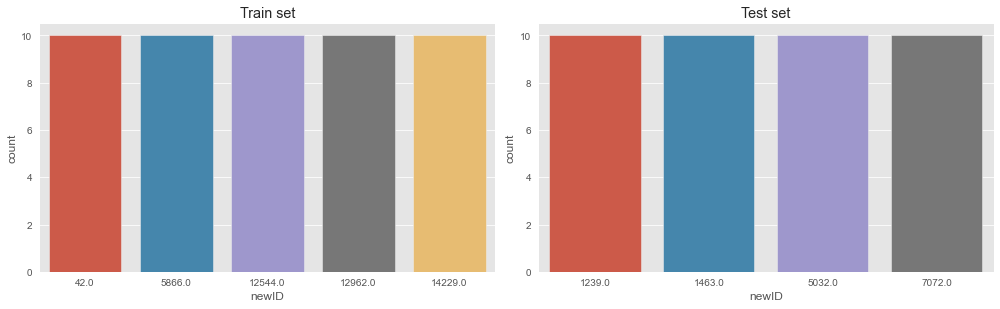

In [1090]:


print('\n\n연속되는 10개의 데이터가 없는 newID들 수정후')
line_clear()
tmp = pd.DataFrame()
for i in del_count_10_train['index']: tmp=pd.concat([tmp,engin_train[engin_train['newID']==i]])
plt.style.use('ggplot')
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
sns.countplot(x='newID',data = tmp)
plt.title("Train set")


tmp = pd.DataFrame()
for i in del_count_10_test['index']: tmp=pd.concat([tmp,engin_test[engin_test['newID']==i]])
plt.subplot(2,2,2)
sns.countplot(x='newID',data = tmp)
plt.title("Test set")
plt.tight_layout()

plt.show()

### pivot 데이터셋 만들기

In [1122]:
# pivot을 위한 구분자 생성
engin_train['index'] = list(np.array(range(1,11)).astype(str))*int((len(engin_train)/10))
engin_test['index'] = list(np.array(range(1,11)).astype(str))*int((len(engin_test)/10))
engin_test

,index,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,...,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,time,dayofweek
0,1,7072.0,29.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.0,0.0,261.0,0.0,7,1.0
1,2,7072.0,29.0,27.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,5.0,0.0,0.0,194.0,0.0,1698.0,0.0,7,1.0
2,3,7072.0,29.0,30.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,204.0,0.0,1346.0,0.0,8,1.0
3,4,7072.0,30.0,35.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,5.0,0.0,0.0,94.0,0.0,1363.0,0.0,9,1.0
4,5,7072.0,30.0,39.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,5.0,0.0,0.0,75.0,0.0,1383.0,0.0,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44745,6,14907.0,121.0,106.0,0.0,0.0,4563.0,0.0,4565.0,0.0,...,1.0,3.0,0.0,9.0,7.0,0.0,0.0,0.0,9,2.0
44746,7,14907.0,132.0,16.0,0.0,0.0,4563.0,0.0,4563.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,5.0
44747,8,14907.0,132.0,16.0,0.0,0.0,4563.0,0.0,4565.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,5.0
44748,9,14907.0,132.0,16.0,0.0,0.0,4563.0,0.0,4565.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,5.0


In [1123]:
trian_cols = engin_train.drop(['newID','index'],axis=1).columns
test_cols = engin_test.drop(['newID','index'],axis=1).columns

# Make pivot train set
df_train_pivot = engin_train.pivot(index='newID',columns='index',values=trian_cols)
pivot_train_cols = engin_train.pivot(index='newID',columns='index',values=trian_cols).columns

pivot_cols = []
for x,y in pivot_train_cols: pivot_cols.append(x+'_'+y)

df_train_pivot.columns = pivot_cols
df_train_pivot.reset_index(inplace=True)

df_train_pivot_y = df_train_pivot['blocked_1'] 
df_train_pivot_x = df_train_pivot.drop(['blocked_1','blocked_10','blocked_2','blocked_3','blocked_4','blocked_5','blocked_6','blocked_7','blocked_8','blocked_9'],axis=1)




# Make pivot test set
df_test_pivot_x = engin_test.pivot(index='newID',columns='index',values=test_cols)
pivot_test_cols = engin_test.pivot(index='newID',columns='index',values=test_cols).columns

pivot_cols = []
for x,y in pivot_test_cols: pivot_cols.append(x+'_'+y)
    
df_test_pivot_x.columns = pivot_cols
df_test_pivot_x.reset_index(inplace=True)

engin_train = engin_train.drop('index',axis=1)
engin_test = engin_test.drop('index',axis=1)

print('train set pivot shape : ',df_train_pivot_x.shape)
print('test set pivot shape : ',df_test_pivot_x.shape)

train set pivot shape :  (10441, 381)
test set pivot shape :  (4475, 381)


# 모델링 시작
> ###### 1. 2차원 데이터
> ###### 2. pivot 데이터

#### 간략한 알고리즘도
#### 해당 데이터셋은 제제대상(1)의 여부가 비제재 대상(0)보다 많은 값을 가지고 있었다. 그래서 1로 예측할 가능성이 높다고 생각을 하였고, 아래의 3개의 모델을 이용하여 정밀도와 재현율을 안정 시키고자한다.
  
ex)

    LGBM_engin 예측값 : 1 
    LGBM_2d    예측값 : 1  -> 최종 예측값 : 1
    LGBM_pivot 예측값 : 1
    
    LGBM_engin 예측값 : 1 
    LGBM_2d    예측값 : 0  -> 최종 예측값 : 0
    LGBM_pivot 예측값 : 1
    
ex처럼 하나라도 0을 예측한다면 0으로 최종 판별한다.
    

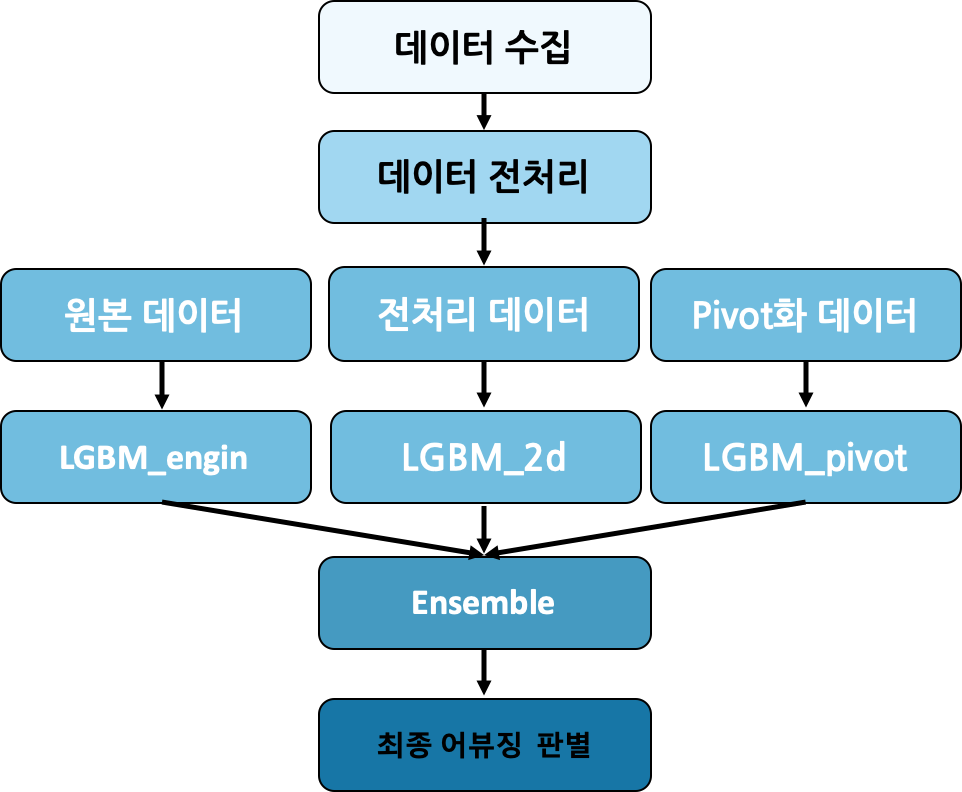

### 2차원 데이터 모델링
> 1. Train_Validation set Split
> 2. Lgbm Hyperparameter 수정 
> 3. 성능 비교

##### 2차원 데이터의 경우 Train set을 split시에  newID가 섞이지 않도록 한다. newID별로 3차원 데이터로 만든뒤 섞고 reshape 과정을 거치자

In [515]:
def value_insert_nan(df):
    cnt =  10 - len(df)
    empty_data = [[np.nan] * len(df.columns) for i in range(cnt)]
    
    empty_df = pd.DataFrame(empty_data, columns=df.columns)
    tmp = pd.concat([df,empty_df],axis=0).reset_index(drop=True)
    return tmp

# 3차원 데이터로 모아주기
def return_3d_shape(df):
    return int(len(df)/10),10,int(len(df.columns))

df_train_2d=df_train_2d.dropna()
# 2시점 전까지 전처리한 데이터
for i in list(del_count_10_train['index']):
    value_insert_df = value_insert_nan(df_train_2d[df_train_2d['newID']==i])
    df_train_2d = pd.concat([value_insert_df,df_train_2d[df_train_2d['newID']!=i]],axis=0).reset_index(drop=True)

cols_2d = df_train_2d.columns

df_train_2d_zip = np.array(df_train_2d).reshape(return_3d_shape(df_train_2d))
df_train_2d_zip.shape


engin_train=engin_train.dropna()
# 가장 초기 train data
for i in list(del_count_10_train['index']):
    value_insert_df = value_insert_nan(engin_train[engin_train['newID']==i])
    engin_train = pd.concat([value_insert_df,engin_train[engin_train['newID']!=i]],axis=0).reset_index(drop=True)

cols_engin = engin_train.columns

engin_train_zip = np.array(engin_train).reshape(return_3d_shape(engin_train))
engin_train_zip.shape


(10441, 10, 40)

In [819]:
df_train_2d_x ,df_valid_2d_x = train_test_split(df_train_2d_zip,test_size=0.2)

df_train_2d_x = pd.DataFrame(df_train_2d_x.reshape(len(df_train_2d_x)*10,62),columns=cols_2d).dropna()
df_valid_2d_x = pd.DataFrame(df_valid_2d_x.reshape(len(df_valid_2d_x)*10,62),columns=cols_2d).dropna()

df_train_2d_x = df_train_2d_x.astype(float)
df_valid_2d_x = df_valid_2d_x.astype(float)

df_train_2d_y = df_train_2d_x['blocked']
df_train_2d_x = df_train_2d_x.drop(['blocked','newID'],axis=1)

df_valid_2d_y = df_valid_2d_x['blocked']
valid_newID_2d = df_valid_2d_x['newID']
df_valid_2d_x = df_valid_2d_x.drop(['blocked','newID'],axis=1)


### 전처리한 2차원 데이터와 원본데이터의 성능 비교를 위해 원본 데이터를 전처리된 train,validaion의 newID와 똑같은 데이터로 split 해준다

In [859]:

engin_train = pd.merge(engin_train,pd.DataFrame(set(valid_newID_2d),columns=['newID']).reset_index(),how='left',on='newID')
engin_train = engin_train.fillna('train')

df_train_engin_y = engin_train[engin_train['index']=='train']['blocked'].astype(float)
df_train_engin_x = engin_train[engin_train['index']=='train'].drop(['newID','blocked','index'],axis=1).astype(float)

df_valid_engin_y = engin_train[engin_train['index']!='train']['blocked'].astype(float)
valid_newID_engin = engin_train[engin_train['index']!='train']['newID'].astype(float)
df_valid_engin_x = engin_train[engin_train['index']!='train'].drop(['newID','blocked','index'],axis=1).astype(float)




### 하이퍼파라미터 수정후 원본 데이터와 전처리한 데이터의 성능은 차이가 없다고 할 수 있다.

In [893]:
#lgbm 원본 데이터 학습 시작
model_engin = lgbm.LGBMClassifier(objective='binary', n_estimators=5000,max_depth=10, bagging_fraction=0.8, num_leaves=10
                            ,learning_rate=0.001468,subsample=0.85)                   
                                                 
model_engin.fit(df_train_engin_x, df_train_engin_y, eval_metric='auc', 
          eval_set=[(df_train_engin_x, df_train_engin_y),(df_valid_engin_x, df_valid_engin_y)], early_stopping_rounds=199, verbose=500)


print(confusion_matrix(df_valid_engin_y, model_engin.predict(df_valid_engin_x)))
print('f1 score : ', f1_score(df_valid_engin_y, model_engin.predict(df_valid_engin_x)))
print('accuracy_score : ',accuracy_score(df_valid_engin_y, model_engin.predict(df_valid_engin_x)))

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.85 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 199 rounds
[500]	training's auc: 0.850093	training's binary_logloss: 0.488324	valid_1's auc: 0.854253	valid_1's binary_logloss: 0.475957
[1000]	training's auc: 0.853954	training's binary_logloss: 0.427073	valid_1's auc: 0.856574	valid_1's binary_logloss: 0.411142
[1500]	training's auc: 0.857178	training's binary_logloss: 0.401606	valid_1's auc: 0.858868	valid_1's binary_logloss: 0.384189
[2000]	training's auc: 0.860351	training's binary_logloss: 0.389509	valid_1's auc: 0.86064	valid_1's binary_logloss: 0.371844
[2500]	training's auc: 0.863095	training's binary_logloss: 0.382902	valid_1's auc: 0.861725	valid_1's binary_logloss: 0.365561
[3000]	training's auc: 0.865579	training's binary_logloss: 0.379018	valid_1's auc: 0.862893	valid_1's binary_logloss: 0.362192
[3500]	training's auc: 0.867562	training's binary_logloss: 0

In [906]:
# lgbm 전처리 데이터 학습 시작
model_2d = lgbm.LGBMClassifier(objective='binary', n_estimators=2500,max_depth=30, bagging_fraction=0.9, num_leaves=30
                            ,learning_rate=0.005,subsample=0.9)                   
                         
                         
model_2d.fit(df_train_2d_x, df_train_2d_y, eval_metric = ['auc'], 
          eval_set=[(df_train_2d_x, df_train_2d_y),(df_valid_2d_x, df_valid_2d_y)], early_stopping_rounds=200, verbose=500)

print(confusion_matrix(df_valid_2d_y, model_2d.predict(df_valid_2d_x)))
print('f1_score : ' ,f1_score(df_valid_2d_y, model_2d.predict(df_valid_2d_x)))
print('accuracy_score : ',accuracy_score(df_valid_2d_y, model_2d.predict(df_valid_2d_x)))


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.883458	training's binary_logloss: 0.378601	valid_1's auc: 0.873871	valid_1's binary_logloss: 0.368257
[1000]	training's auc: 0.894724	training's binary_logloss: 0.354612	valid_1's auc: 0.877231	valid_1's binary_logloss: 0.350918
[1500]	training's auc: 0.903616	training's binary_logloss: 0.34517	valid_1's auc: 0.879654	valid_1's binary_logloss: 0.347848
[2000]	training's auc: 0.911665	training's binary_logloss: 0.337334	valid_1's auc: 0.88067	valid_1's binary_logloss: 0.346697
[2500]	training's auc: 0.918881	training's binary_logloss: 0.330177	valid_1's auc: 0.881818	valid_1's binary_logloss: 0.345633
Did not meet early stopping. Best iteration is:
[2500]	training's auc: 0.918881	training's binary_logloss: 0.330177	valid_1's auc: 0.881818	valid_1's binary_logloss: 0.345633
[[ 5423  2826]

### Pivot 데이터 모델링 시작

In [917]:
df_train_pivot = pd.concat([df_train_pivot_x, df_train_pivot_y],axis=1).reset_index(drop=True)
df_train_pivot.head()

,newID,char_jobcode_1,char_jobcode_10,char_jobcode_2,char_jobcode_3,char_jobcode_4,char_jobcode_5,char_jobcode_6,char_jobcode_7,char_jobcode_8,...,dayofweek_10,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,dayofweek_8,dayofweek_9,blocked_1
0,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,0
1,6.0,0,0,0,0,0,0,0,0,0,...,2,4,4,5,5,6,0,0,1,0
2,7.0,0,0,0,0,0,0,0,0,0,...,5,4,5,5,5,5,5,5,5,0
3,8.0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,0
4,11.0,0,0,0,0,0,0,0,0,0,...,2,4,4,4,5,5,0,0,2,0


In [918]:
df_train_pivot = pd.merge(df_train_pivot,pd.DataFrame(set(valid_newID_2d),columns=['newID']).reset_index(),how='left',on='newID')
df_train_pivot = df_train_pivot.fillna('train')

df_train_pivot_y = df_train_pivot[df_train_pivot['index']=='train']['blocked_1'].astype(float)
df_train_pivot_x = df_train_pivot[df_train_pivot['index']=='train'].drop(['newID','blocked_1','index'],axis=1).astype(float)

df_valid_pivot_y = df_train_pivot[df_train_pivot['index']!='train']['blocked_1'].astype(float)
valid_newID_pivot = df_train_pivot[df_train_pivot['index']!='train']['newID'].astype(float)
df_valid_pivot_x = df_train_pivot[df_train_pivot['index']!='train'].drop(['newID','blocked_1','index'],axis=1).astype(float)


# print(df_train_pi_x.value_counts())
print(df_train_pivot_y.value_counts())
print(df_valid_pivot_y.value_counts())
df_valid_pivot_x


1    4988
0    3364
Name: blocked_1, dtype: int64
1    1258
0     831
Name: blocked_1, dtype: int64


,char_jobcode_1,char_jobcode_10,char_jobcode_2,char_jobcode_3,char_jobcode_4,char_jobcode_5,char_jobcode_6,char_jobcode_7,char_jobcode_8,char_jobcode_9,...,dayofweek_1,dayofweek_10,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,dayofweek_8,dayofweek_9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,4.0,4.0,4.0,5.0,5.0,0.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,6.0,4.0,4.0,4.0,4.0,5.0,5.0,6.0,6.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10410,119.0,120.0,119.0,119.0,119.0,119.0,120.0,120.0,120.0,120.0,...,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
10412,119.0,132.0,119.0,119.0,119.0,119.0,119.0,120.0,120.0,120.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
10416,119.0,120.0,119.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
10427,119.0,120.0,119.0,119.0,119.0,119.0,119.0,119.0,119.0,120.0,...,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0


In [963]:
# lgbm pivot 데이터 학습 시작
model_pivot = lgbm.LGBMClassifier(objective='binary', n_estimators=4000, bagging_fraction=0.8,max_depth=15, num_leaves=15
                            ,learning_rate=0.00065,subsample=0.8)                   
                         
                         
model_pivot.fit(df_train_pivot_x, df_train_pivot_y, eval_metric = ['auc'], 
          eval_set=[(df_train_pivot_x, df_train_pivot_y),(df_valid_pivot_x, df_valid_pivot_y)], early_stopping_rounds=300, verbose=500)


print(confusion_matrix(df_valid_pivot_y,model_pivot.predict(df_valid_pivot_x)))
print('f1_score : ' ,f1_score(df_valid_pivot_y, model_pivot.predict(df_valid_pivot_x)))
print('accuracy_score : ',accuracy_score(df_valid_pivot_y, model_pivot.predict(df_valid_pivot_x)))


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.879553	training's binary_logloss: 0.553647	valid_1's auc: 0.868552	valid_1's binary_logloss: 0.549691
[1000]	training's auc: 0.888888	training's binary_logloss: 0.484327	valid_1's auc: 0.870657	valid_1's binary_logloss: 0.480703
[1500]	training's auc: 0.89668	training's binary_logloss: 0.439335	valid_1's auc: 0.873506	valid_1's binary_logloss: 0.437215
[2000]	training's auc: 0.903387	training's binary_logloss: 0.40867	valid_1's auc: 0.873663	valid_1's binary_logloss: 0.409289
[2500]	training's auc: 0.908796	training's binary_logloss: 0.38666	valid_1's auc: 0.876305	valid_1's binary_logloss: 0.389607
[3000]	training's auc: 0.913654	training's binary_logloss: 0.370208	valid_1's auc: 0.878561	valid_1's binary_logloss: 0.375803
[3500]	training's auc: 0.918078	training's binary_logloss: 0.35

### LGBM_engin, LGBM_2d, LGBM_pivot Ensemble Start

#### LGBM_engin 결과

In [1131]:
def conversion_proba(x):
    if x>=0.6: return 1
    else : return 0
pre_engin = model_engin.predict(df_valid_engin_x)
predict_engin = pd.concat([valid_newID_engin.reset_index(drop=True), pd.DataFrame(pre_engin,columns=['predict_engin']),df_valid_engin_y.reset_index(drop=True)],axis=1)
predict_engin = predict_engin.groupby('newID').mean().reset_index()
predict_engin['predict_engin'] = predict_engin['predict_engin'].apply(conversion_proba)
predict_engin = predict_engin.astype(int)
predict_engin = predict_engin.sort_values('newID')

print(confusion_matrix(predict_engin['blocked'],predict_engin['predict_engin']))
print('accuracy : ',accuracy_score(predict_engin['blocked'],predict_engin['predict_engin']))
print('f1_score : ',f1_score(predict_engin['blocked'],predict_engin['predict_engin']))

# model_pivot.predict(df_valid_pivot_x)



[[ 521  304]
 [   3 1261]]
accuracy :  0.8530397319291527
f1_score :  0.8914810887239307


#### LGBM_2d 결과

In [1134]:

pre_2d = model_2d.predict(df_valid_2d_x)
predict_2d = pd.concat([valid_newID_2d, pd.DataFrame(pre_2d,columns=['predict_2d']),df_valid_2d_y.reset_index(drop=True)],axis=1)
predict_2d = predict_2d.groupby('newID').mean().reset_index()
predict_2d['predict_2d'] = predict_2d['predict_2d'].apply(conversion_proba)
predict_2d = predict_2d.astype(int)
predict_2d = predict_2d.sort_values('newID')

print(confusion_matrix(predict_2d['blocked'],predict_2d['predict_2d']))
print('accuracy : ',accuracy_score(predict_2d['blocked'],predict_2d['predict_2d']))
print('f1_score : ',f1_score(predict_2d['blocked'],predict_2d['predict_2d']))



[[ 545  340]
 [  10 1194]]
accuracy :  0.8324557204404021
f1_score :  0.8721694667640614


#### LGBM_pivot 결과

In [1132]:
pre_pivot = model_pivot.predict(df_valid_pivot_x)
predict_pivot = pd.concat([valid_newID_pivot.reset_index(drop=True), pd.DataFrame(pre_pivot,columns=['predict_pivot']),df_valid_pivot_y.reset_index(drop=True)],axis=1)
predict_pivot.columns =[ 'newID','predict_pivot','blocked']
predict_pivot = predict_pivot.sort_values('newID')

print(confusion_matrix(predict_pivot['blocked'],predict_pivot['predict_pivot']))
print('accuracy : ',accuracy_score(predict_pivot['blocked'],predict_pivot['predict_pivot']))
print('f1_score : ' ,f1_score(predict_pivot['blocked'],predict_pivot['predict_pivot']))


[[ 540  285]
 [   9 1255]]
accuracy :  0.8592628051699378
f1_score :  0.8951497860199715


### Ensemble 결과 

In [1133]:
df_all_predict = pd.DataFrame()
df_all_predict['newID'] = predict_pivot['newID']
df_all_predict['blocked'] = predict_pivot['blocked']
df_all_predict['sum_predict'] = predict_pivot['predict_pivot']+predict_2d['predict_2d']+predict_engin['predict_engin']

def return_blocked(x):
    if x==3: return 1
    else: return 0
df_all_predict['final_predict'] = df_all_predict['sum_predict'].apply(return_blocked)


print(confusion_matrix(df_all_predict['blocked'],df_all_predict['final_predict']))
print('accuracy : ',accuracy_score(df_all_predict['blocked'],df_all_predict['final_predict']))
print('f1_score : ' ,f1_score(df_all_predict['blocked'],df_all_predict['final_predict']))


[[ 558  267]
 [  21 1243]]
accuracy :  0.8621349928195309
f1_score :  0.8961788031723145


### Submission 파일 제출 및 모델 저장

##### df_test_2d 데이터 생성

In [1101]:
# newID 별로 1,2전행의 값을 넣어주는 과정
newID = set(engin_test_x['newID'])
tmp= dict()
for i in newID:
    tmp[str(i)] = engin_test_x[engin_test_x['newID']==i].reset_index(drop=True)
    tmp[str(i)]['actionSessionAmountA_1'] = tmp[str(i)]['actionSessionAmountA'].shift(1)
    tmp[str(i)]['actionSessionAmountB_1'] = tmp[str(i)]['actionSessionAmountB'].shift(1)
    tmp[str(i)]['actionSessionAmountL_1'] = tmp[str(i)]['actionSessionAmountL'].shift(1)
    tmp[str(i)]['actionSessionAmountN_1'] = tmp[str(i)]['actionSessionAmountN'].shift(1)
    tmp[str(i)]['char_level_1'] = tmp[str(i)]['char_level'].shift(1)
    tmp[str(i)]['char_jobcode_1'] = tmp[str(i)]['char_jobcode'].shift(1)
    
    tmp[str(i)]['actionSessionAmountA_2'] = tmp[str(i)]['actionSessionAmountA'].shift(2)
    tmp[str(i)]['actionSessionAmountB_2'] = tmp[str(i)]['actionSessionAmountB'].shift(2)
    tmp[str(i)]['actionSessionAmountL_2'] = tmp[str(i)]['actionSessionAmountL'].shift(2)
    tmp[str(i)]['actionSessionAmountN_2'] = tmp[str(i)]['actionSessionAmountN'].shift(2)
    tmp[str(i)]['char_level_2'] = tmp[str(i)]['char_level'].shift(2)
    tmp[str(i)]['char_jobcode_2'] = tmp[str(i)]['char_jobcode'].shift(2)

    


df_test_2d_x = pd.DataFrame()
# 분리시켰던 newID별 데이터를 한곳으로 합치는 과정
for i in newID:
    tmp[str(i)] = tmp[str(i)].fillna(0)
    df_test_2d_x = pd.concat([df_test_2d_x,tmp[str(i)]],axis=0)

# 해당 Action 컬럼들의 차분값 계산
df_test_2d_x['sub_actionA_1'] = df_test_2d_x['actionSessionAmountA'].sub(df_test_2d_x['actionSessionAmountA_1'])
df_test_2d_x['sub_actionB_1'] = df_test_2d_x['actionSessionAmountB'].sub(df_test_2d_x['actionSessionAmountB_1'])
df_test_2d_x['sub_actionL_1'] = df_test_2d_x['actionSessionAmountL'].sub(df_test_2d_x['actionSessionAmountL_1'])
df_test_2d_x['sub_actionN_1'] = df_test_2d_x['actionSessionAmountN'].sub(df_test_2d_x['actionSessionAmountN_1'])

df_test_2d_x['sub_actionA_2'] = df_test_2d_x['actionSessionAmountA'].sub(df_test_2d_x['actionSessionAmountA_2'])
df_test_2d_x['sub_actionB_2'] = df_test_2d_x['actionSessionAmountB'].sub(df_test_2d_x['actionSessionAmountB_2'])
df_test_2d_x['sub_actionL_2'] = df_test_2d_x['actionSessionAmountL'].sub(df_test_2d_x['actionSessionAmountL_2'])
df_test_2d_x['sub_actionN_2'] = df_test_2d_x['actionSessionAmountN'].sub(df_test_2d_x['actionSessionAmountN_2'])

#level 의 차분값 계산 -> level의 차분값이 (-) 라면 새로운 캐릭으로 바꾼것으로 볼수있다.
lev_sub_value_1 = df_test_2d_x['char_level'].sub(df_test_2d_x['char_level_1'])
lev_sub_value_2 = df_test_2d_x['char_level'].sub(df_test_2d_x['char_level_2'])

df_test_2d_x['same_level_1'] = lev_sub_value_1
df_test_2d_x['same_level_2'] = lev_sub_value_2

df_test_2d_x = df_test_2d_x.reset_index(drop=True)
df_test_2d_x





,newID,char_jobcode,char_level,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,...,sub_actionA_1,sub_actionB_1,sub_actionL_1,sub_actionN_1,sub_actionA_2,sub_actionB_2,sub_actionL_2,sub_actionN_2,same_level_1,same_level_2
0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,7.0,1.0,0.0,24.0,7.0,1.0,0.0,10.0,10.0
1,1.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,561.0,37.0,331.0,263.0,585.0,44.0,332.0,263.0,21.0,31.0
2,1.0,0.0,37.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,-418.0,19.0,-251.0,-196.0,143.0,56.0,80.0,67.0,6.0,27.0
3,1.0,0.0,55.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1044.0,137.0,595.0,639.0,626.0,156.0,344.0,443.0,18.0,24.0
4,1.0,0.0,73.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,589.0,782.0,778.0,454.0,1633.0,919.0,1373.0,1093.0,18.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44745,8189.0,30.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-10.0,40.0,18.0,7.0,139.0,192.0,170.0,171.0,2.0,4.0
44746,8189.0,30.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.0,0.0,65.0,73.0,111.0,40.0,83.0,80.0,1.0,3.0
44747,8189.0,30.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1308.0,681.0,697.0,865.0,1429.0,681.0,762.0,938.0,6.0,7.0
44748,8189.0,30.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,-361.0,406.0,281.0,1896.0,320.0,1103.0,1146.0,5.0,11.0


#### 각 test 데이터 예측 후 최종 테이블 생성

In [1136]:
result_df = pd.DataFrame()
result_df['newID'] = df_test_2d_x['newID']
result_df['predict_2d'] = model_2d.predict(df_test_2d_x.drop('newID',axis=1).astype(float))
result_df['predict_engin'] = model_engin.predict(engin_test_x.drop('newID',axis=1).astype(float))

result_df = result_df.groupby('newID').mean().reset_index()
result_df['predict_2d'] = result_df['predict_2d'].apply(conversion_proba)
result_df['predict_engin'] = result_df['predict_engin'].apply(conversion_proba)

result_df['predict_pivot'] = model_pivot.predict(df_test_pivot_x.drop('newID',axis=1).astype(int))

result_df['sum_predict'] = result_df['predict_2d']+result_df['predict_engin']+result_df['predict_pivot']


# pd.DataFrame(model_pivot.predict(df_test_pivot_x.drop('newID',axis=1).astype(float))).value_counts()
# 
# 
result_df['blocked']=result_df['sum_predict'].apply(return_blocked)
result_df[['newID','blocked']]

,newID,blocked
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0
...,...,...
4470,14896.0,0
4471,14901.0,0
4472,14902.0,0
4473,14904.0,0


#### 제출 파일 생성 및 모델 저장

In [1117]:
result_df[['newID','blocked']].to_csv('submission.csv',encoding='euc-kr')

In [1143]:
# import sklearn.external.joblib as extjoblib
import joblib
joblib.dump(model_engin,'lgb_engin.pkl')
joblib.dump(model_2d,'lgb_2d.pkl')
joblib.dump(model_pivot,'lgb_pivot.pkl')

['lgb_pivot.pkl']

# 개선사항
1. newID별로 3차원 데이터로 묶어서 딥러닝인 cnn모델 학습 시도를 해볼 필요가 있다.
2. 클린 유저의 경우 캐릭터의 닉네임을 성의껏 짓는다고 생각한다. 반대로 어뷰징 유저는 그렇지 못할것이다. 컬럼으로 캐릭터 닉네임을 수집할수 있다면 성능을 높일 수 있는 좋은 시도라고 생각한다. 수집이 가능하다면 시도해 보자.